In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [3]:
df = pd.read_csv('winequality-red.csv',';')

# V.1 Exploring the green reds

#### a) Write a function that will plot a scatterplot matrix of your red wine data

In [4]:
import matplotlib.pyplot as plt

def scatterplot_matrix(data, good_threshold, bad_threshold, save_plot=False):

    numvars, numdata = data.shape
    numdata -= 1 # without quality
    
    fig, axes = plt.subplots(nrows=numdata, ncols=numdata, figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    clean_data = data[(data["quality"] > good_threshold) |
                      (data["quality"] < bad_threshold)]
    colors = ['g' if k > good_threshold else 'r' if k < bad_threshold else 'white'
              for k in clean_data["quality"]]
    
    for i in range(numdata):
        axes[i,i].annotate(clean_data.columns[i], (0.5, 0.5),
            xycoords='axes fraction', ha='center', va='center')
        j = 0
        for j in range(numdata):
            if (j == i):
                continue   
            axes[i, j].scatter(clean_data.iloc[:, j], clean_data.iloc[:, i],
                               c=colors, marker='.')
    if (save_plot == True):
        plt.savefig("scatter_matrix.png")
    
    plt.show()

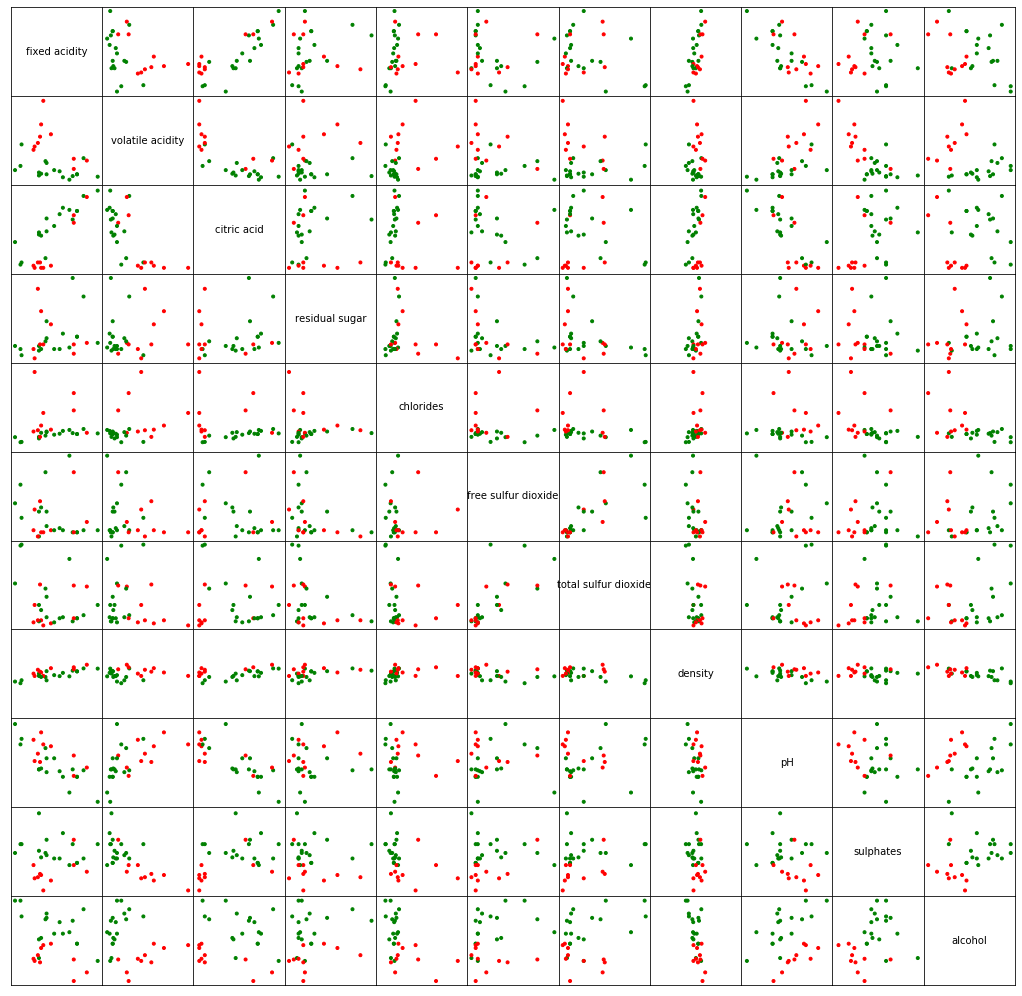

In [5]:
scatterplot_matrix(df, 7, 4, True)

#### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?
We better choose the characteristics that most affect the quality of the wine. The graphs show that the highest quality of wine depends on:
* Alcohol - The more alcohol, the better the wine,
* Sulphates - The more sulfates, the better the wine,
* Volatile acidity - The lower the volatile acidity, the better the wine

# V.2 Learning to perceptron

#### a) Implementing a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
* Utilizes the heaviside step activation function (discrete version)

#### b) Implementing a function to train perceptron

In [32]:
class Perceptron(object):
    
    def __init__(self, data, seed = None):
        self.data    = data
        
        if seed:
            random.seed(seed)
            
        self.bias    = random.uniform(-1, 1)
        self.weights = [random.uniform(-1, 1) for i in range(data.shape[1] - 1)]
        print(self.weights)
        
    def predict(self, input_row):
        summ = self.bias
        for i, value in enumerate(input_row):
            summ += value * self.weights[i]
        return 1.0 if summ > 0.0 else 0.0

    def train_epoch(self):
        epoch_error = 0.0
        for row in self.data:
#             print(row)
            true_answer = row[-1]
            prediction = self.predict(row[:-1])
            error = true_answer - prediction
            epoch_error += error**2
            self.bias += self.learning_rate * error
            for i, value in enumerate(row[:-1]):
                self.weights[i] += self.learning_rate * error * value
        return epoch_error

    def train_data(self, a_epochs, learning_rate, verbose=False):
        self.learning_rate = learning_rate
        current_epoch = 0
        performance = []
#         print(self.weights)
        
        while True:
            epoch_error = self.train_epoch()
            
            tuple = (current_epoch, epoch_error, self.weights, self.bias)
            performance.append(tuple)
            if (verbose):
                print(tuple)
            
            if (a_epochs == 0):
                if epoch_error == 0:
                    break
            else:
                if current_epoch >= a_epochs:
                    break
            current_epoch += 1
               
        return performance
        

In [35]:
columns_to_loc = ['pH', 'alcohol', 'goodness']
bad_quality = 4
good_quality = 7

if good_quality < bad_quality:
    raise ValueError('Good threshold is smaller to bad_threshold')
wine_data = df[(df['quality'] > good_quality) | (df['quality'] < bad_quality)]
wine_data = wine_data.assign(goodness = pd.Series(wine_data['quality'] > good_quality, dtype=int))
wine_data = wine_data.reset_index(drop=True)
selected_data = wine_data.loc[:, columns_to_loc]
print(selected_data)

      pH  alcohol  goodness
0   3.35    12.80         1
1   3.23    12.60         1
2   3.56    12.90         1
3   2.88     9.80         1
4   3.22    13.40         1
5   3.25     9.00         0
6   3.15    11.70         1
7   3.15    11.00         1
8   3.15    11.00         1
9   3.16     8.40         0
10  3.72    14.00         1
11  3.63    10.70         0
12  3.46    12.70         1
13  3.38     9.90         0
14  3.48    11.00         0
15  3.21    12.50         1
16  2.98    11.80         1
17  3.20    13.10         1
18  3.35    11.70         1
19  3.50    14.00         1
20  3.50    10.90         0
21  3.32     9.80         0
22  3.23    10.00         1
23  3.23    11.30         1
24  3.31     9.70         0
25  3.40    10.20         0
26  3.55     9.95         0
27  3.24    11.40         1


In [46]:
new_percetpron = Perceptron(selected_data.values)

performance = new_percetpron.train_data(0, 0.005, False)

print(performance[-1])

[-0.168543701000055, 0.7760233760030579]
(12112, 0.0, [-3.632993700997659, 0.8632733760030924], 3.1032943116163563)


#### c) Function to check if perceptron works correctly
* The first plot show the number of errors perceptron made in each epoch
* The second plot show the decision boundary of our perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot also shade ‘good’ and ‘bad’ areas!

In [4]:
def plot_errors(ax, performance):
    epochs = [i[0] for i in performance]
    errors = [i[1] for i in performance]
    ax.plot(epochs, errors)
#     ax.set_xlim([0, len(performance)])
#     ax.set_ylim(ymin=-1)
    ax.set_title('Errors count by epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    
def plot_boundary_decision(ax, wine_data, performance, epoch):
    x_name = columns_to_loc[1]
    y_name = columns_to_loc[0]
    x = wine_data.loc[:, x_name]
    y = wine_data.loc[:, y_name]

    x_min = x.min() - ((x.min() * 7) / 100)
    x_max = x.max() + ((x.min() * 5) / 100)
    y_min = y.min() - ((x.min() * 1) / 100)
    y_max = y.max() + ((x.min() * 1) / 100)
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]

    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept

    ax.set_title('Decision boundary on epoch: ' + str(performance[epoch][0]))
    ax.set_xlabel(x_name)
    ax.set_xlim([x_min, x_max])
    ax.set_ylabel(y_name)
    ax.set_ylim([y_min, y_max])

    ax.plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax.fill_between(x_coords, y_coords, y_max, color='#ff9999')
    ax.fill_between(x_coords, y_coords, y_min, color='#99ff99')
    
def draw_scatter(ax, wine_data):
    good_wines = wine_data[(wine_data['goodness'] == 1)]
    bad_wines = wine_data[(wine_data['goodness'] == 0)]

    ax.scatter(good_wines.loc[:, columns_to_loc[1]], good_wines.loc[:, columns_to_loc[0]],
                    c=['g'], label='good wines (> {} score)'.format(good_quality))
    ax.scatter(bad_wines.loc[:, columns_to_loc[1]], bad_wines.loc[:, columns_to_loc[0]],
                    c=['r'], label='bad wines (< {} score)'.format(bad_quality))
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
def plot_performance(performance, wine_data, epoch=-1, save_plot=False):
    if epoch > len(performance) - 1:
        raise ValueError('number of epochs should be less than {}'.format(len(performance)))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
    plot_errors(axes[0], performance)
    plot_boundary_decision(axes[1], wine_data, performance, epoch)
    draw_scatter(axes[1], wine_data)

    if (save_plot == True):
        plt.savefig("plot_performance.png")
    plt.show()

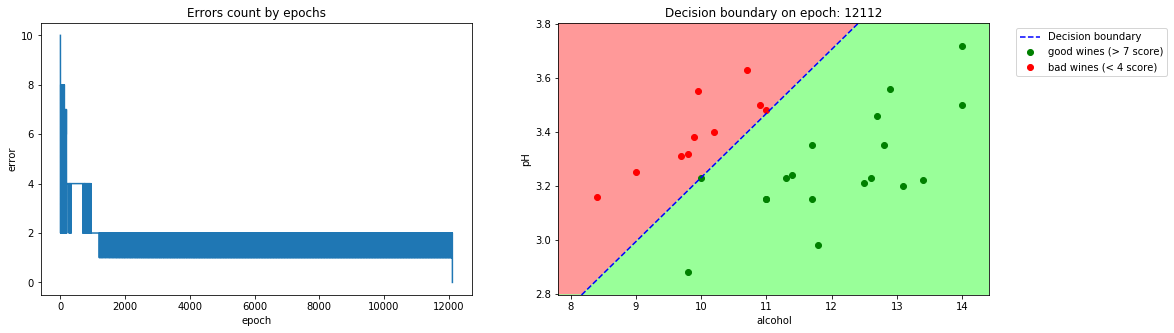

In [47]:
plot_performance(performance, selected_data, -1, True)

#### d) Make perceptron learning more efficiently (Feature Scaling)

In [5]:
def normalize(column):
    return (column - column.mean()) / (column.max() - column.min())

In [12]:
normalized_data = wine_data.loc[:, columns_to_loc]
# print(normalize_data)
for column in columns_to_loc[: -1]:
    normalized_data[column] = normalize(normalized_data[column])
#     normalize_data[column] = normalize(normalize_data[column])
#     print(normalize_data[column])
# print(normalized_data)

In [48]:
# print("Original data performance:")
# new_percetpron = Perceptron(selected_data.values)
# performance = new_percetpron.train_data(0, 0.005, False)
# print(performance[-1], '\n')

print("Normalized data performance:")
normalized_percetpron = Perceptron(normalized_data.values)
normalized_performance = normalized_percetpron.train_data(0, 0.005, False)
print(normalized_performance[-1])

Original data performance:
[0.667012535569093, -0.0630105180049838]
(16873, 0.0, [-3.6391874644275086, 0.8694894819950286], 3.061586897447501) 

Normalized data performance:
[0.8911829772317446, 0.9661767563897976]
(296, 0.0, [-0.44138292412879704, 0.7240833252673639], 0.12795962528855853)


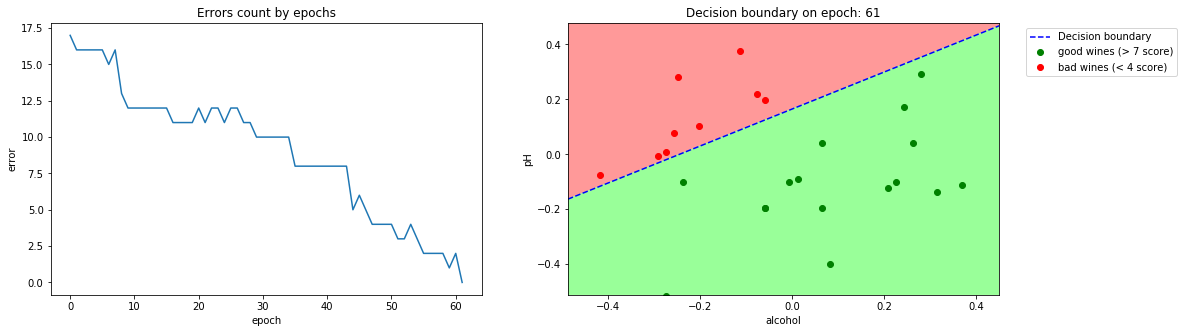

In [14]:
plot_performance(normalized_performance, normalized_data, -1, True)

# V.3 My fair ADALINE

#### a) Marvin notices and chides you for torturing your perceptron.

We can try to train our perceptron with quality higher then 6 or lower then 5. In this case perceptron couldn't find correct weights combination to avoid mistakes. This happens because perceptron algorithm works only with linear correlations and it will never found correct parameters to satisfy not linear formula

In [22]:
columns_to_loc = ['volatile acidity', 'alcohol', 'goodness']
bad_quality = 5
good_quality = 6

if good_quality < bad_quality:
    raise ValueError('Good threshold is smaller to bad_threshold')
wine_data = df[(df['quality'] > good_quality) | (df['quality'] < bad_quality)]
wine_data = wine_data.assign(goodness = pd.Series(wine_data['quality'] > good_quality, dtype=int))
wine_data = wine_data.reset_index(drop=True)
selected_data = wine_data.loc[:, columns_to_loc]

# for column in columns_to_loc[: -1]:
selected_data[columns_to_loc[0]] = normalize(selected_data[columns_to_loc[0]])

print(selected_data)

     volatile acidity  alcohol  goodness
0            0.118334    10.00         1
1            0.070389     9.50         1
2           -0.135091    10.50         1
3            0.077238     9.00         0
4           -0.066597     9.70         1
..                ...      ...       ...
275         -0.155638    10.90         1
276         -0.073447    11.20         1
277         -0.080296    11.40         1
278          0.056690    10.55         1
279         -0.107693    11.60         1

[280 rows x 3 columns]


[0.23886067399070732, 0.7906772196044207]


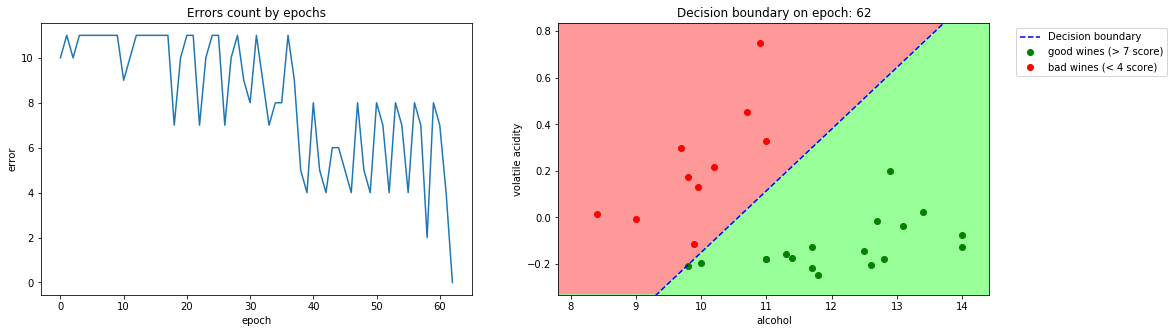

In [56]:
new_percetpron = Perceptron(selected_data.values)
performance = new_percetpron.train_data(0, 0.005, False)
plot_performance(performance, selected_data, -1, True)

#### b), c) Implement an ADALINE with training function

The adaline network may be trained using the delta learning rule. The delta learning rule may also b called as least mean square (LMS) rule or   Widrow-Hoff rule. This learning rule is found to minimize the mean-squared error between the activation and the target value

In [7]:
class Mode(object):
    ONLINE = 0
    BATCH = 1

class Adaline(object):
    
    def __init__(self, data, seed = None):
        self.data    = data
        
        if seed:
            random.seed(seed)
            
        self.bias    = 0.0001 * random.uniform(-1, 1)
        self.weights = [0.0001 * random.uniform(-1, 1) for i in range(data.shape[1] - 1)]
        
    def quantizer(self, predict):
        return 1 if predict > 0.5 else 0

    def predict(self, input_row):
        summ = self.bias
        for i, value in enumerate(input_row):
            summ += value * self.weights[i]
        return 1 / (1 + math.exp(-(summ)))

    def validate_accuracy(self, data):
        num_correct = 0

        for row in data:
            num_correct += self.quantizer(self.predict(row[:-1])) == row[-1]
        
        return num_correct / len(data)
    
    def train_epoch(self, mode): 
        epoch_errors = []
        epoch_error = 0.0
        
        for row in self.data:
            true_answer = row[-1]
            prediction = self.predict(row[:-1])
            error = true_answer - prediction
            epoch_error += self.quantizer(prediction) != true_answer
            
            if (mode == Mode.ONLINE):
                self.bias += self.learning_rate * error
                for i, value in enumerate(row[:-1]):
                    self.weights[i] += self.learning_rate * error * value
            elif (mode == Mode.BATCH):
                epoch_errors.append(error)
        
        if (mode == Mode.BATCH):
            self.bias += self.learning_rate * sum(epoch_errors)
            for r, row in enumerate(self.data):
                for i, value in enumerate(row[:-1]):
                    self.weights[i] += self.learning_rate *\
                        epoch_errors[r] * value
        
        return epoch_error

    def train_data(self, a_epochs, learning_rate, mode, verbose=False):
        self.learning_rate = learning_rate
        current_epoch = 0
        performance = []
        
        while True:
            epoch_error = self.train_epoch(mode)
            
            tuple = (current_epoch, epoch_error, self.weights, self.bias)
            performance.append(tuple)
            if (verbose):
                print('Current epoch = {}, errors = {}'.format(
                    current_epoch, epoch_error))
            
            if (a_epochs == 0):
                if epoch_error == 0:
                    break
            else:
                if current_epoch >= a_epochs:
                    break
            current_epoch += 1
               
        return performance
        

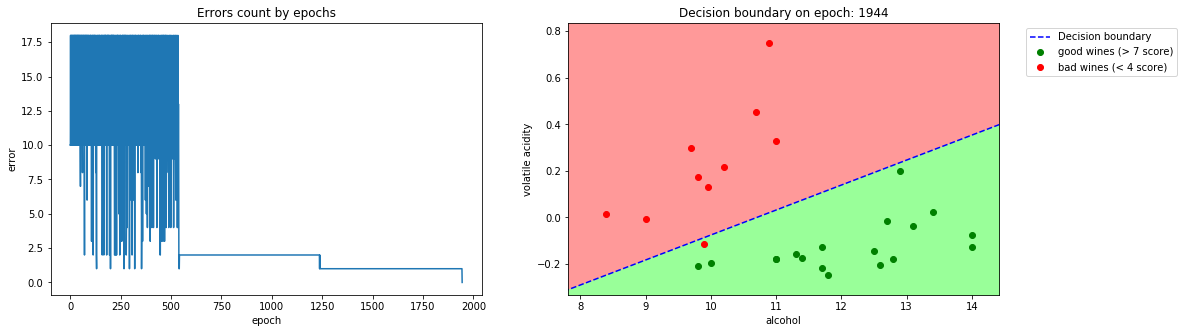

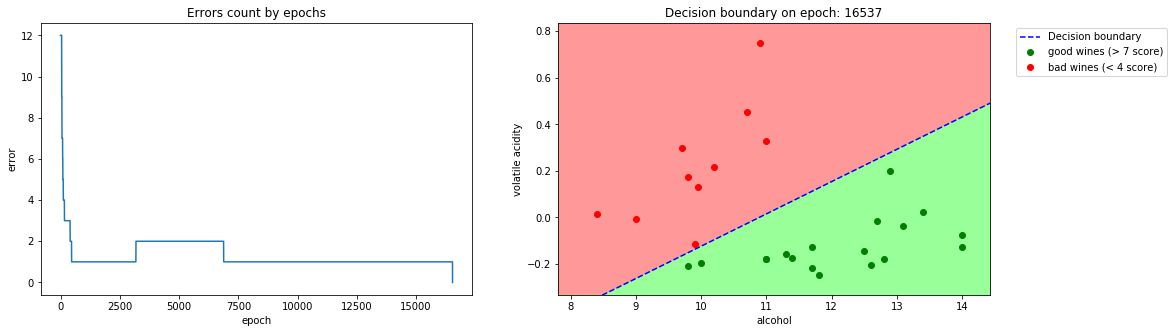

In [63]:
adaline = Adaline(selected_data.values, 100)
adaline_performance = adaline.train_data(0, 0.05, Mode.BATCH)
plot_performance(adaline_performance, selected_data, -1, True)

adaline = Adaline(selected_data.values, 100)
adaline_performance = adaline.train_data(0, 0.05, Mode.ONLINE)
plot_performance(adaline_performance, selected_data, -1, True)

#### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary

The best learning rate is 0.05

Performance with learning rate  0.0005


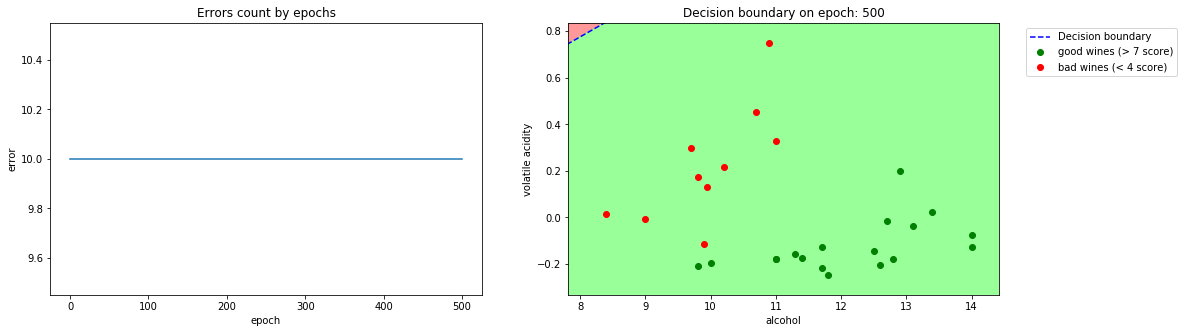

Performance with learning rate  0.005


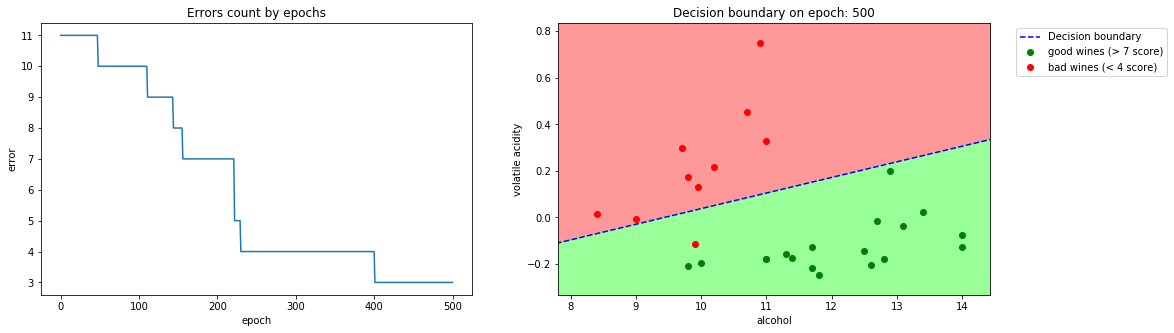

Performance with learning rate  0.05


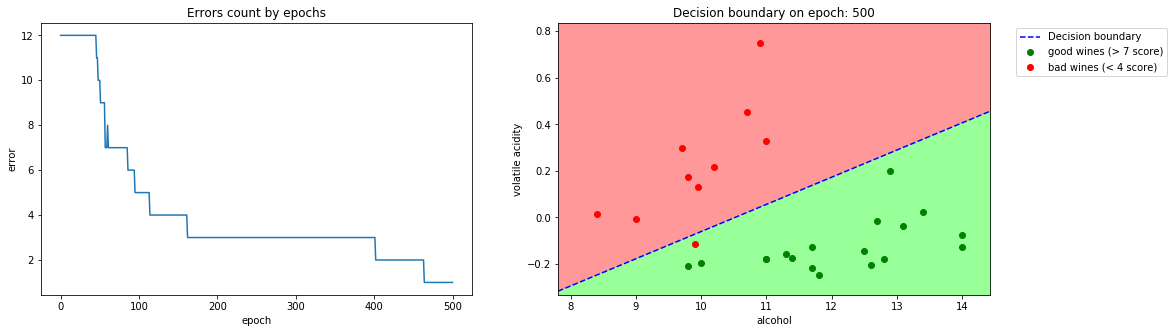

Performance with learning rate  0.5


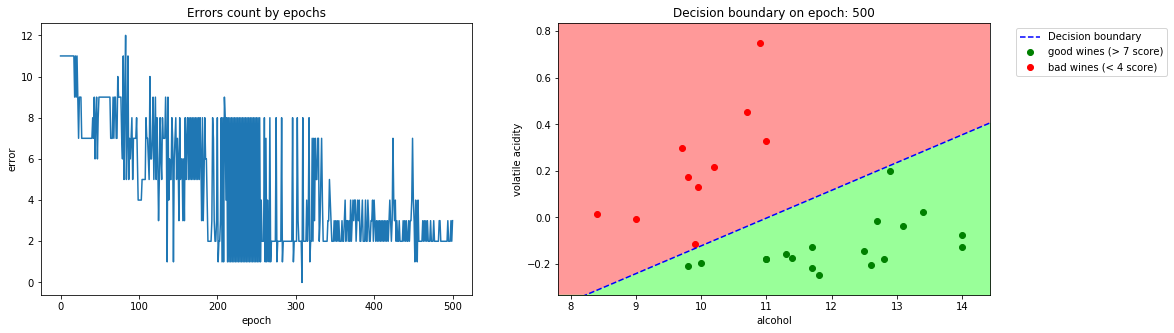

In [65]:
test_learning_rates = [0.0005, 0.005, 0.05, 0.5]

for lr in test_learning_rates:
    print("Performance with learning rate ", lr)
    adaline = Adaline(selected_data.values, 100)
    adaline_performance = adaline.train_data(500, lr, Mode.ONLINE)
    plot_performance(adaline_performance, selected_data, -1, True)

In [19]:
# print(selected_data)
new_adaline = Adaline(selected_data.values)

adaline_performance = new_adaline.train_data(300, 0.05, Mode.ONLINE)

print(adaline_performance[-1])

(300, 28.0, [-18.34894341846064, 2.2931128562921743], -20.55401349560649)


# V.4 Advanced wine sampling and resampling

#### a) function that uses the holdout method to partition the red wine data into a training and a validation set

In [20]:
def data_partitioning(data, proportion=0.7):
    train_data = data.sample(frac=proportion)
    validation_data = data.drop(train_data.index)

    print('Train data size: {}'.format(train_data.shape[0]))
    print('Validation data size: {}'.format(validation_data.shape[0]))
    
    return (train_data, validation_data)

Train data size: 22
Validation data size: 6
Samples in train set: 22
Samples in validation set: 6


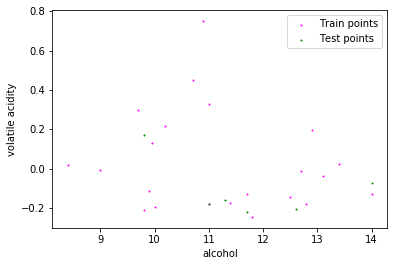

In [90]:
# Functions/Variables to change!
# You may need to change the function and variable
train, test = data_partitioning(selected_data, 0.8)

# ============ Do not modify any code below this line! ============
print('Samples in train set: {}\nSamples in validation set: {}'.format(len(train), len(test)))
assert(not any([True for index in train.index if index in test.index]))
# Because we want to be really really sure, plot train and test sets in same plot.
# Visually check that train and test point labels change for a given point if you run holdout many times
# Setting the split_fraction to a low or high number should make the difference very obvious
fig1, ax1 = plt.subplots()
train.plot(x='alcohol', y='volatile acidity', label='Train points', kind='scatter', color='magenta', s = 1, ax = ax1)
test.plot(x='alcohol', y='volatile acidity', label='Test points', kind='scatter', color='green', s = 1, ax = ax1)

In [21]:
train_data, validation_data = data_partitioning(selected_data, 0.7)

adaline = Adaline(train_data.values)
train_performance = adaline.train_data(500, 0.05, Mode.ONLINE)

accuracy = adaline.validate_accuracy(validation_data.values)

print('Model accuracy: {0:.0%}'.format(accuracy))

Train data size: 196
Validation data size: 84
Model accuracy: 92%


#### b) Write a function that generates a k-fold cross-validation dataset

In [88]:
def k_fold_partition(selected_data, k = 5, shuffle = False):

    if (shuffle == True):
        selected_data = selected_data.sample(frac=1)
    
    result = []
    part = selected_data.shape[0] / k
#     print(part)
    
    end = 0.0
    for i in range(k):
        start = end
        end = round(start + part) if i + 1 < k else selected_data.shape[0]
#         print(end)
        data = selected_data[int(start):int(end)]
        train = selected_data.drop(data.index)
        result.append((train, data))
    return result

In [89]:
print(selected_data)
# Functions/Variables to change!
k_folds = 9
folds = k_fold_partition(selected_data, k_folds, False)
data = selected_data

# ============ Do not modify any code below this line! ============
assert(len(folds) == k_folds)
corr_xval_sizes = [(len(data) // k_folds) + 1 if (i < len(data) % k_folds) else (len(data) // k_folds)
for i in range(k_folds)]
print(corr_xval_sizes)
corr_train_sizes = [len(data) - xval_size for xval_size in corr_xval_sizes]
print(corr_train_sizes)
user_train_xval_sizes = [(len(train), len(xval)) for train, xval in [tup for tup in folds]]
print(user_train_xval_sizes)
assert(list(zip(corr_train_sizes, corr_xval_sizes)) == user_train_xval_sizes)
assert(not any([any([True for index in train.index if index in xval.index]) for train, xval in folds]))
train_lst, xval_lst = zip(*folds)
assert(all([[len(xval.index.intersection(xval_lst[j].index)) == 0 for j in range(len(xval_lst)) if i != j]
for i, xval in enumerate(xval_lst)]))
print('(Train, Xval) lengths for {} folds:\n{}'.format(k_folds, [(len(train), len(xval)) for train, xval in folds]))

     volatile acidity  alcohol  goodness
0            0.118334    10.00         1
1            0.070389     9.50         1
2           -0.135091    10.50         1
3            0.077238     9.00         0
4           -0.066597     9.70         1
..                ...      ...       ...
275         -0.155638    10.90         1
276         -0.073447    11.20         1
277         -0.080296    11.40         1
278          0.056690    10.55         1
279         -0.107693    11.60         1

[280 rows x 3 columns]
[32, 31, 31, 31, 31, 31, 31, 31, 31]
[248, 249, 249, 249, 249, 249, 249, 249, 249]
[(248, 32), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31)]
(Train, Xval) lengths for 9 folds:
[(248, 32), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31), (249, 31)]


In [26]:
splited_data = k_fold_partition(selected_data, 7)

for train_data, validation_data in splited_data:
    adaline = Adaline(train_data.values, 1000)
    train_performance = adaline.train_data(500, 0.05, Mode.ONLINE)

    accuracy = adaline.validate_accuracy(validation_data.values)

    print('Model accuracy: {0:.0%}'.format(accuracy))

Model accuracy: 90%
Model accuracy: 98%
Model accuracy: 78%
Model accuracy: 92%
Model accuracy: 100%
Model accuracy: 88%
Model accuracy: 82%


#### c) What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation?

In [91]:
def adaline_cross_validation(splited_data, lr = 0.005, epochs = 300):
    accuracy = 0
    
    for train_data, validation_data in splited_data:
        adaline = Adaline(train_data.values, 1000)
        train_performance = adaline.train_data(epochs, lr, Mode.ONLINE)

        accuracy += adaline.validate_accuracy(validation_data.values) * 100
    return round(accuracy / len(splited_data))

In [25]:
splited_data = k_fold_partition(selected_data, 7)

test_epochs = [100, 200, 300]
test_learnin_rates = [0.0005, 0.005, 0.05, 0.5]

max_accuracy = 0
max_accuracy_epochs = 0
max_accuracy_learning_rate = 0

for epochs in test_epochs:
    for lr in test_learning_rates:
        accuracy = int(adaline_cross_validation(splited_data, lr, epochs))
        print('Model accuracy: {0}% (epochs={1}, learning_rate={2})'.format(accuracy, epochs, lr))        
        if (accuracy < max_accuracy):
            continue
        
        if (accuracy > max_accuracy |
            (accuracy == max_accuracy &
             epochs < max_accuracy_epochs)):
            max_accuracy = accuracy
            max_accuracy_epochs = epochs
            max_accuracy_learning_rate = lr
            
print('==================================================================')
print('Best model accuracy ({0}%) params: \
epochs={1}, learning_rate={2}'.format(max_accuracy,
                                      max_accuracy_epochs,
                                      max_accuracy_learning_rate))
print('==================================================================')

Model accuracy: 78% (epochs=100, learning_rate=0.0005)
Model accuracy: 86% (epochs=100, learning_rate=0.005)
Model accuracy: 86% (epochs=100, learning_rate=0.05)
Model accuracy: 85% (epochs=100, learning_rate=0.5)
Model accuracy: 78% (epochs=200, learning_rate=0.0005)
Model accuracy: 89% (epochs=200, learning_rate=0.005)
Model accuracy: 90% (epochs=200, learning_rate=0.05)
Model accuracy: 86% (epochs=200, learning_rate=0.5)
Model accuracy: 78% (epochs=300, learning_rate=0.0005)
Model accuracy: 91% (epochs=300, learning_rate=0.005)
Model accuracy: 90% (epochs=300, learning_rate=0.05)
Model accuracy: 89% (epochs=300, learning_rate=0.5)
Best model accuracy (91%) params: epochs=300, learning_rate=0.005


# V.5 Adventures in the Nth dimension

#### a) Training ADALINE with different numbers and types of chemical factors

In [92]:
columns_to_loc = [
    ['volatile acidity', 'alcohol', 'pH', 'goodness'],
    ['pH', 'alcohol', 'sulphates', 'goodness'],
    ['pH', 'alcohol', 'fixed acidity', 'goodness'],
    ['pH', 'alcohol', 'sulphates', 'volatile acidity', 'goodness'],
    ['pH', 'alcohol', 'sulphates', 'volatile acidity', 'fixed acidity', 'goodness'],
    ['volatile acidity', 'alcohol', 'citric acid', 'goodness'],
    ['volatile acidity', 'alcohol', 'density', 'goodness'],
]
bad_quality = 5
good_quality = 6

if good_quality < bad_quality:
    raise ValueError('Good threshold is smaller to bad_threshold')
wine_data = df[(df['quality'] > good_quality) | (df['quality'] < bad_quality)]
wine_data = wine_data.assign(goodness = pd.Series(wine_data['quality'] > good_quality, dtype=int))
wine_data = wine_data.reset_index(drop=True)

for columns in columns_to_loc:
    print('testing columns - {} ...'. format(columns))
    selected_data = wine_data.loc[:, columns]
    for it_column in columns[: -1]:
        selected_data[it_column] = normalize(selected_data[it_column])
    
    splited_data = k_fold_partition(selected_data, 7)
    accuracy = adaline_cross_validation(splited_data)
    print('Model accuracy: {0}%'.format(accuracy))

testing columns - ['volatile acidity', 'alcohol', 'pH', 'goodness'] ...
Model accuracy: 89.0%
testing columns - ['pH', 'alcohol', 'sulphates', 'goodness'] ...
Model accuracy: 86.0%
testing columns - ['pH', 'alcohol', 'fixed acidity', 'goodness'] ...
Model accuracy: 84.0%
testing columns - ['pH', 'alcohol', 'sulphates', 'volatile acidity', 'goodness'] ...
Model accuracy: 89.0%
testing columns - ['pH', 'alcohol', 'sulphates', 'volatile acidity', 'fixed acidity', 'goodness'] ...
Model accuracy: 89.0%
testing columns - ['volatile acidity', 'alcohol', 'citric acid', 'goodness'] ...
Model accuracy: 89.0%
testing columns - ['volatile acidity', 'alcohol', 'density', 'goodness'] ...
Model accuracy: 89.0%


#### b) What does the decision boundary for N factors look like?
Decision boundary for N factors is (N - 1) dimentional hyperplane 

# V.6 Marvin’s rebuttal

#### a) Find a way to successfully classify the Pan-Galactic Gargle Blaster dataset

In [27]:
df = pd.read_csv('Pan Galactic Gargle Blaster.csv',';')

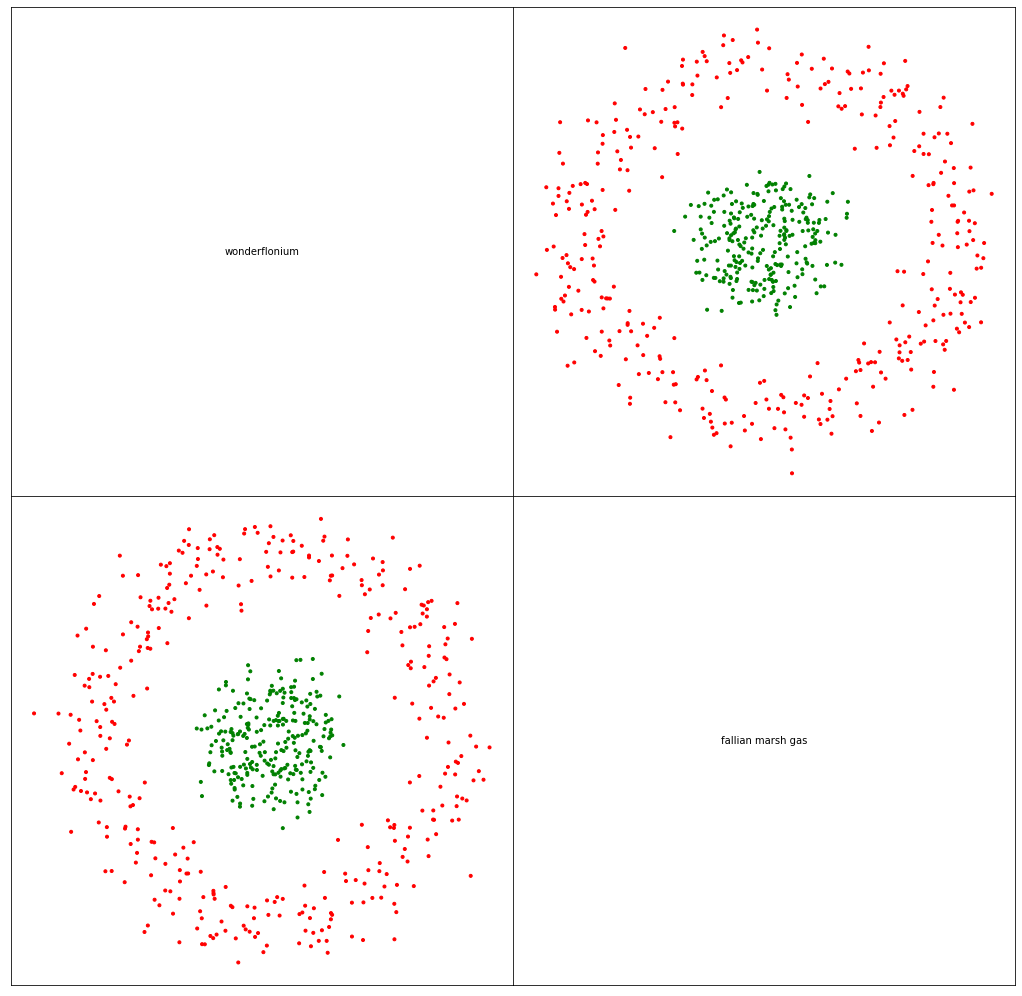

In [28]:
scatterplot_matrix(df, 7, 4, True)

Need to convert data into polar coordinate system

In [29]:
columns_to_loc = ['r', 'phi', 'goodness']
bad_quality = 5
good_quality = 5

galactic_data = df.assign(goodness = pd.Series(df['quality'] > good_quality, dtype=int))
galactic_data['wonderflonium'] = normalize(galactic_data['wonderflonium'])
galactic_data['fallian marsh gas'] = normalize(galactic_data['fallian marsh gas'])

x1 = galactic_data.loc[:, 'wonderflonium']
x2 = galactic_data.loc[:, 'fallian marsh gas']

galactic_data = galactic_data.assign(r=pd.Series(x1 * x1 + x2 * x2).pow(1./2))
galactic_data = galactic_data.assign(
    phi=pd.Series([math.atan2(x, y) for (x, y) in zip(x1, x2)]))

selected_data = galactic_data.loc[:, columns_to_loc]
print(selected_data)

            r       phi  goodness
0    0.477213 -0.073737         0
1    0.399123 -0.945096         0
2    0.343789  1.095098         0
3    0.100239  1.180546         1
4    0.420019 -0.024690         0
..        ...       ...       ...
995  0.081911  1.053750         1
996  0.289107 -2.518047         0
997  0.444384  2.851429         0
998  0.434788 -3.014141         0
999  0.071005 -0.832802         1

[1000 rows x 3 columns]


In [30]:
train_data, validation_data = data_partitioning(selected_data, 0.7)

adaline = Adaline(train_data.values)
performance = adaline.train_data(70, 0.005, Mode.ONLINE, False)
print(performance[-1])
accuracy = adaline.validate_accuracy(validation_data.values)

print('Model accuracy: {0:.0%}'.format(accuracy))

Train data size: 700
Validation data size: 300
(70, 0.0, [-10.105920503570228, 0.0019949735612532415], 2.4933498862312935)
Model accuracy: 100%


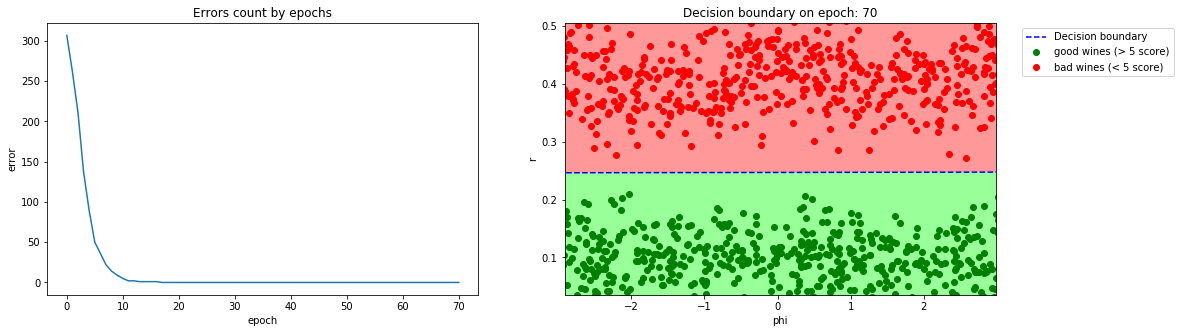

In [31]:
plot_performance(performance, selected_data, -1, False)